In [9]:
import torch
import torch.nn as nn
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
import seaborn as sns

from functools import partial
from tqdm.notebook import tqdm
from sconf import Config

from IPython.display import clear_output

import sys

sys.path.append("..")

from classes import MLP, MultiTaskLoss
from utils import non_markovian_midprice

In [10]:
config = Config("config.yaml")

In [11]:
rng = np.random.default_rng(123)

# num_paths = config.num_paths
# num_timesteps = config.num_timesteps
# final_time = config.final_time
# initial_price = config.initial_price
# decomp_dim = config.decomp_dim
# num_episodes = config.num_episodes
# batch_size = config.batch_size
# learning_rate = config.learning_rate

num_paths = 1
num_timesteps = 250
final_time = 1
initial_price = 1
decomp_dim = 5
num_episodes = 10_000
batch_size = 1
dt = final_time / num_timesteps

inital_prices = np.ones((1, num_paths)) * initial_price

kappa_true = 1

permenant_price_impact_func = lambda x: kappa_true * x
# permenant_price_impact_func = lambda x: kappa_true * np.sign(x) * np.sqrt(np.abs(x))
# kernel_function = lambda x,y: (np.abs((x-y)+1e-3)**(0.51-1))
kernel_function = lambda x, y: np.exp(-((x - y) ** 2) / (0.1))
# kernel_function = lambda x, y: np.exp(-np.abs((x - y)))
K0 = kernel_function(0, 0)

nu_vals = rng.uniform(-100, 100, size=(num_timesteps, num_paths))

# Generate Data

In [12]:
sigma_true = 0.01
sim_prices, noise_process = non_markovian_midprice(
    inital_prices=inital_prices,
    permenant_price_impact_func=permenant_price_impact_func,
    nu_vals=nu_vals,
    kernel_function=kernel_function,
    dt=dt,
    rng=rng,
    num_paths=num_paths,
    num_timesteps=num_timesteps,
    sigma=sigma_true,
)

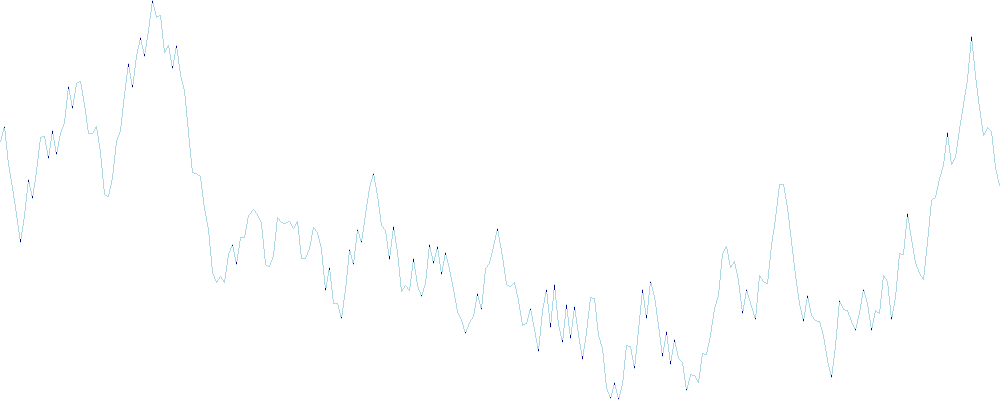

In [13]:
n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(
    walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0
)
img = tf.shade(agg, how="eq_hist")

img

# NN Approach

In [14]:
def generate_time_one_time_two():

    time_one = (
                torch.FloatTensor(rng.uniform(0, num_timesteps, batch_size)).reshape(
                    -1, 1
                )
                * dt
            )
    time_two = (
        torch.FloatTensor(rng.uniform(0, num_timesteps, batch_size)).reshape(
            -1, 1
        )
        * dt
    )

    return time_one, time_two

In [17]:
learning_rate = 5e-5

network = MLP(decomp_dim=decomp_dim, 
              learn_price_impact=False, 
              sigma_start=sigma_true, 
              kappa_start=kappa_true)

mtloss = MultiTaskLoss(num_losses=7, 
                       lagrangian=True)

optimizer = torch.optim.Adam(
    params=[*network.parameters(), *mtloss.parameters()], lr=learning_rate
)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

if not network.learn_price_impact:
    assert np.allclose(sigma_true - network.sigma, 0), (sigma_true, network.sigma, sigma_true - network.sigma)
    assert np.allclose(kappa_true - network.kappa, 0), (kappa_true, network.kappa, kappa_true - network.kappa)

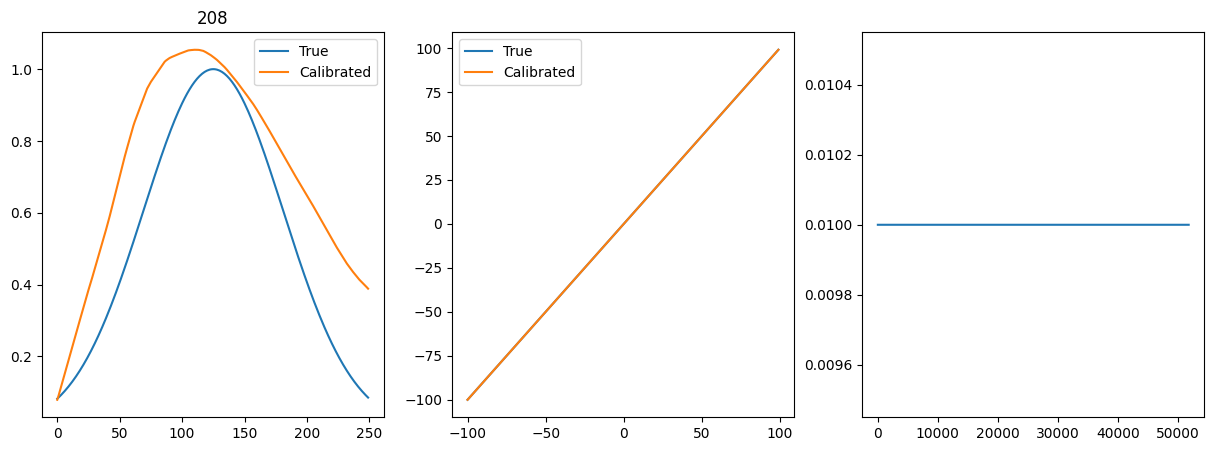

In [18]:
loss_vals = {}
sigma_tracker = {}
kappa_tracker = {}
for episode in tqdm(range(num_episodes), position=0, leave=True):
    loss_vals[episode] = []
    sigma_tracker[episode] = []
    kappa_tracker[episode] = []
    for batch_index in range(1, int(num_paths / batch_size) + 1):

        lower_bound = int((batch_index - 1) * batch_size)
        upper_bound = int((batch_index) * batch_size)

        B_n_t = torch.zeros((batch_size, decomp_dim))

        true_vals = sim_prices[:, lower_bound:upper_bound]
        batch_nu_vals = nu_vals[:, lower_bound:upper_bound]

        shuffeled_timesteps = np.arange(1, num_timesteps - 1)

        # Shuffle Timestamps
        rng.shuffle(shuffeled_timesteps)

        for timestep in shuffeled_timesteps:

            true_vals_t = torch.FloatTensor(true_vals[timestep, :])
            true_vals_t_plus_one = torch.FloatTensor(true_vals[timestep + 1, :])

            batch_nu_vals_t = torch.FloatTensor(batch_nu_vals[timestep])
            price_impacts = network.permenant_price_impact_func(
                batch_nu_vals_t
            ).reshape(batch_size)

            time_tensor = torch.FloatTensor([timestep * dt])
            f_vals = network(time_tensor)
            K_t_t = torch.FloatTensor([1])

            # Calculate Second f(X_t, t; \theta) term
            # Calcutate f_n'(t)
            B_n_t = torch.zeros((1, batch_size, decomp_dim))
            all_time_tensor = (torch.arange(0, timestep) * dt).reshape(-1, 1)
            all_f_vals = network(all_time_tensor).reshape(timestep, 1, decomp_dim)
            d_B_n_s = (
                all_f_vals
                * network.permenant_price_impact_func(
                    torch.FloatTensor(batch_nu_vals[:timestep])
                ).reshape(timestep, batch_size, 1)
                * dt
            )

            for val in d_B_n_s:
                B_n_t = B_n_t + val

            # grad_time_tensor = torch.FloatTensor([timestep*dt])
            # grad_time_tensor.requires_grad = True
            # f_prime_vals = torch.autograd.functional.jacobian(network,
            #                                                   grad_time_tensor,
            #                                                   create_graph=True)
            # f_prime_vals = f_prime_vals.flatten()

            delta = torch.FloatTensor([dt])
            time_minus_delta = time_tensor - delta
            time_plus_delta = time_tensor + delta
            f_prime_vals = (
                (network(time_plus_delta) - network(time_minus_delta)) / (2 * delta)
            ).flatten()

            # Calculate first f(X_t, t; \theta) term
            f_x_t_one = price_impacts.reshape(batch_size) * K_t_t

            f_x_t_two = (
                B_n_t.reshape(batch_size, decomp_dim)
                * f_prime_vals.reshape(1, decomp_dim)
            ).sum(dim=1)

            f_x_t = f_x_t_one + f_x_t_two

            L_x_t = network.sigma
            term_one = 0.5 * torch.log(torch.abs(2 * torch.pi * (L_x_t**2) * dt))

            term_two = (((true_vals_t_plus_one - true_vals_t) - f_x_t * dt) ** 2) / (
                2 * dt * (L_x_t**2)
            )

            likely_hood_loss = (term_one + term_two).mean()
            ##################################################################################
            ##################################################################################
            # Enforcing K(t,t) = K(s,s)
            time_one, _ = generate_time_one_time_two()
            K_one_one = network.approx_func(time_one, time_one).flatten()
            
            # Ensure K(t,t) = 1
            kernel_error_one = torch.abs(K_one_one - 1)**2
            ##################################################################################
            time_one, time_two = generate_time_one_time_two()
            K_one_two = network.approx_func(time_one, time_two).flatten()
            # Ensure K(s,t) < 1
            kernel_error_two = torch.maximum(torch.zeros_like(K_one_two), K_one_two-K0).mean()**2
            ##################################################################################
            time_one, _ = generate_time_one_time_two()
            K_one_one = network.approx_func(time_one, time_one).flatten()

            f_prime_vals = (network(time_one+dt) - network(time_one-dt))/(2*dt)
            k_prime_one_one = (K_one_one * f_prime_vals).sum(dim=-1)
            # Ensure K'(t,t) = 0
            kernel_error_three = torch.abs(k_prime_one_one).mean()**2
            ##################################################################################
            time_one, time_two = generate_time_one_time_two()
            K_one_two = network.approx_func(time_one, time_two).flatten()

            delta = (
                torch.FloatTensor(
                    rng.uniform(0, num_timesteps, batch_size)
                ).reshape(-1, 1)
                * dt
            )
            time_one_delta = time_one + delta
            time_two_delta = time_two + delta
            K_one_two_delta = network.approx_func(
                time_one_delta, time_two_delta
            ).flatten()
            # Ensure that K(s,t) - K(s+d, t+d) = 0
            kernel_error_four = torch.abs(K_one_two - K_one_two_delta)**2
            ##################################################################################
            time_one, _ = generate_time_one_time_two()

            # Shift Invariance
            delta = (
                torch.FloatTensor(rng.uniform(0, num_timesteps, batch_size)).reshape(
                    -1, 1
                )
                * dt
            )
            time_one_plus_delta = time_one + delta
            time_one_minus_delta = time_one - delta
            K_one_plus_one_delta = network.approx_func(
                time_one_plus_delta, time_one
            ).flatten()

            K_one_minus_one_delta = network.approx_func(
                time_one_minus_delta, time_one
            ).flatten()

            # Ensure that K(t,t+delta) = K(t,t-delta)
            kernel_error_five = torch.abs(
                K_one_plus_one_delta - K_one_minus_one_delta
            )**2
            ##################################################################################
            time_one, time_two = generate_time_one_time_two()
            K_one_two = network.approx_func(time_one, time_two).flatten()

            # Ensure that K(s,t) > 0
            kernel_error_seven = (
                torch.maximum(torch.zeros_like(K_one_two), -K_one_two)
            )**2
            ##################################################################################
            time_one, _ = generate_time_one_time_two()
            delta = (
                torch.FloatTensor(rng.uniform(0, num_timesteps, batch_size)).reshape(
                    -1, 1
                )
                * dt
            )
            time_one_delta = time_one + delta
            f_prime_s = (network(time_one_delta + dt) - network(time_one_delta - dt)) / (2 * dt)
            k_prime_t_s = (network(time_one) * f_prime_s).sum(dim=-1).flatten()

            # Want the grad to be negative: k'(t,s) < 0
            kernel_error_ten = (
                torch.maximum(torch.zeros_like(k_prime_t_s), k_prime_t_s)
            )**2
            ##################################################################################
            ##################################################################################
            ##################################################################################
            loss_tensor = torch.hstack(
                [
                    likely_hood_loss,
                    kernel_error_one.mean(),
                    kernel_error_two.mean(),
                    kernel_error_three.mean(),
                    kernel_error_four.mean(),
                    kernel_error_five.mean(),
                    # kernel_error_seven.mean(),
                    kernel_error_ten.mean(),
                ]
            )

            if len(loss_tensor) == 1:
                loss = loss_tensor.mean()
            else:
                loss = mtloss(loss_tensor)

            kappa_tracker[episode].append(network.kappa.detach().item())
            sigma_tracker[episode].append(network.sigma.detach().item())
            loss_vals[episode].append(
                {   
                    'mt_loss': loss.detach().item(),
                    **{i: _.detach().item() for i, _ in enumerate(loss_tensor)}
                }
            )

            network.zero_grad()
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            network.zero_grad()
            optimizer.zero_grad()

    # scheduler.step()

    if episode % 2 == 0:
        clear_output(wait=True)
        s = 0.5
        s_val = num_timesteps * s
        kernel_plot = []
        kernel_plot_two = []

        fig, ax = plt.subplots(1, 3, figsize=(15,5))

        for i in range(0, num_timesteps):
            k_s_t = network.approx_func(
                torch.FloatTensor([s_val * dt]).reshape(-1, 1),
                torch.FloatTensor([i * dt]).reshape(1, -1),
            )
            kernel_plot.append(k_s_t.detach().item())

        partial_func = partial(kernel_function, y=s_val * dt)
        for i in range(0, num_timesteps):
            val = partial_func(i * dt)
            kernel_plot_two.append(val)

        ax[0].set_title(episode)
        ax[0].plot(kernel_plot_two, label="True")
        ax[0].plot(kernel_plot, label="Calibrated")
        ax[0].legend()

        pi_plot = []
        pi_plot_true = []

        for plot_val in range(-100, 100):
            pred_pi = network.permenant_price_impact_func(
                torch.FloatTensor([plot_val])
            )
            pi_plot.append(pred_pi.detach().item())

        for plot_val in range(-100, 100):
            val = permenant_price_impact_func(plot_val)
            pi_plot_true.append(val)

        ax[1].plot(range(-100, 100), pi_plot_true, label="True")
        ax[1].plot(range(-100, 100), pi_plot, label="Calibrated")
        ax[1].legend()

        ax[2].plot(np.hstack([_ for _ in sigma_tracker.values()]))

        plt.show()

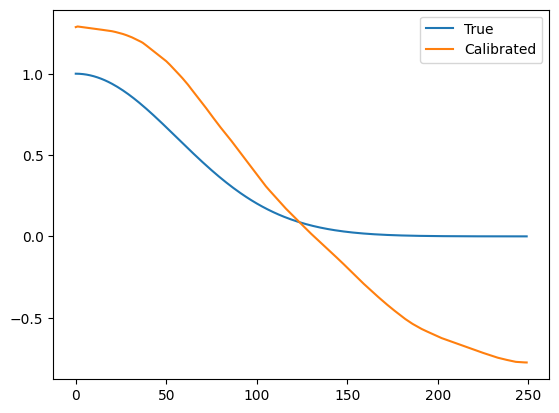

In [ ]:
s = 0
s_val = num_timesteps * s
kernel_plot = []
kernel_plot_two = []

for i in range(0, num_timesteps):
    k_s_t = network.approx_func(
        torch.FloatTensor([s_val * dt]).reshape(-1, 1),
        torch.FloatTensor([i * dt]).reshape(1, -1),
    )
    kernel_plot.append(k_s_t.detach().item())

partial_func = partial(kernel_function, y=s_val * dt)
for i in range(0, num_timesteps):
    val = partial_func(i * dt)
    kernel_plot_two.append(val)

plt.plot(kernel_plot_two, label="True")
plt.plot(kernel_plot, label="Calibrated")
plt.legend()
plt.show()

# Validation Prices

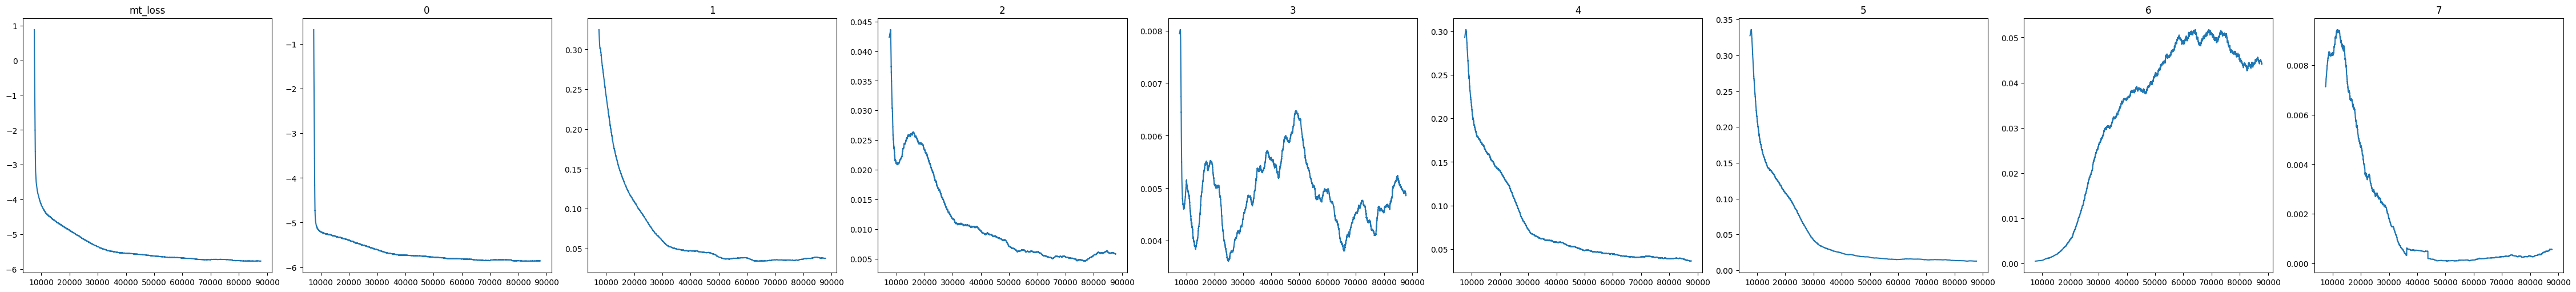

In [ ]:
loss_types = tuple(loss_vals[0][0].keys())

fig, ax = plt.subplots(
    1, len(loss_types), figsize=(5 * len(loss_types), 5), constrained_layout=True
)

for plot_index, loss_type in enumerate(loss_types):
    ax[plot_index].plot(
        pd.concat([pd.DataFrame(loss_vals[_])[loss_type][:] for _ in loss_vals.keys()])
        .rolling(num_timesteps*30)
        .mean()
        .values
    )
    ax[plot_index].set_title(loss_type)

plt.show()

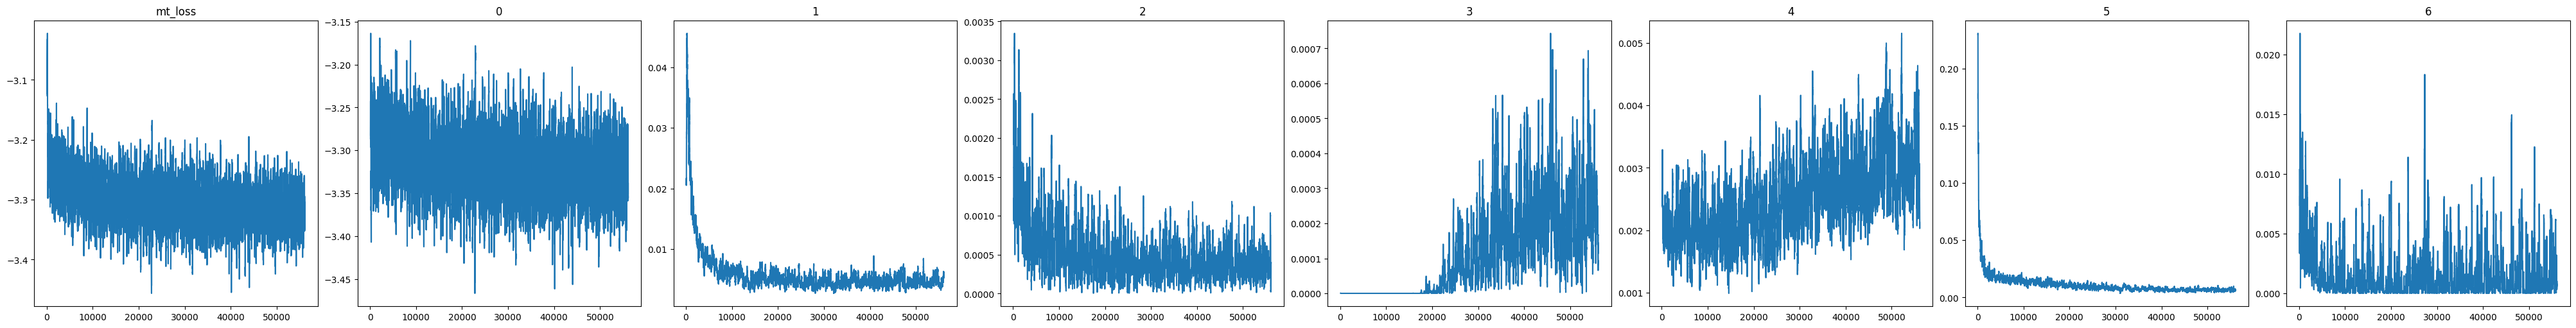

In [ ]:
loss_types = tuple(loss_vals[0][0].keys())

fig, ax = plt.subplots(
    1, len(loss_types), figsize=(5 * len(loss_types), 5), constrained_layout=True
)

for plot_index, loss_type in enumerate(loss_types):
    ax[plot_index].plot(
        pd.concat([pd.DataFrame(loss_vals[_])[loss_type][:] for _ in loss_vals.keys()])
        .rolling(num_timesteps)
        .mean()
        .values
    )
    ax[plot_index].set_title(loss_type)

plt.show()

# Distribution Plots

In [ ]:
val_nu_vals = rng.uniform(-50, 100, size=(num_timesteps, 1_000))
val_inital_prices = np.ones((1, 1_000)) * initial_price
val_sim_prices, _ = non_markovian_midprice(
    inital_prices=val_inital_prices,
    permenant_price_impact_func=permenant_price_impact_func,
    nu_vals=val_nu_vals,
    kernel_function=kernel_function,
    dt=dt,
    rng=rng,
    num_paths=1_000,
    num_timesteps=num_timesteps,
    sigma=sigma_true,
)

In [ ]:
network.eval()

batch_size = 1_000

batch_nu_vals = rng.uniform(-50, 100, size=(num_timesteps, batch_size))

B_n_t = torch.zeros((decomp_dim, batch_size))
S_t = torch.ones((1, batch_size)) * initial_price

B_n_list = [B_n_t.detach().numpy()]
S_t_list = [S_t.detach().numpy()]

for timestep in range(1, num_timesteps):

    price_impacts = network.permenant_price_impact_func(torch.FloatTensor(batch_nu_vals[timestep]))
    net_vals = network(torch.FloatTensor([timestep * dt]))

    f_vals = net_vals

    time_tensor = torch.FloatTensor([timestep * dt])
    time_tensor.requires_grad = True

    f_prime_vals = torch.autograd.functional.jacobian(
        network, time_tensor, create_graph=True
    )

    f_prime_vals = f_prime_vals.flatten()

    kernel_time_t = f_vals.dot(f_vals)
    kernel_price_impact = kernel_time_t * price_impacts * dt

    w_t = (dt**0.5) * torch.randn((batch_size))
    sigma_w_t = network.sigma * w_t

    dB_n_t = torch.tile(f_vals, dims=(batch_size, 1)).T * price_impacts * dt
    B_n_t = B_n_t.detach() + dB_n_t
    B_n_list.append(B_n_t.detach().numpy())

    sum_of_sub_procces = torch.matmul(f_prime_vals, B_n_t) * dt

    dS_t = kernel_price_impact + sigma_w_t + sum_of_sub_procces
    S_t = S_t.detach() + dS_t

    S_t_list.append(S_t.detach().numpy())

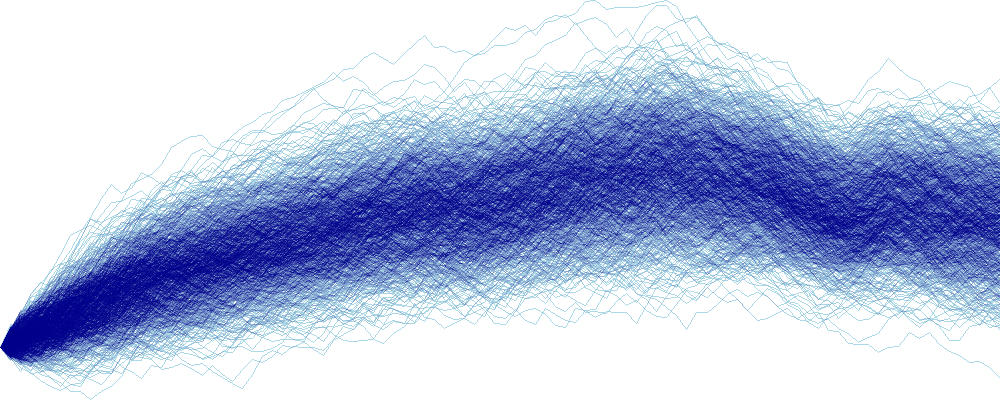

In [ ]:
nn_sim_prices = np.vstack(S_t_list)

n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(nn_sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(
    walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0
)
img = tf.shade(agg, how="eq_hist")

img

# Distribution Plots

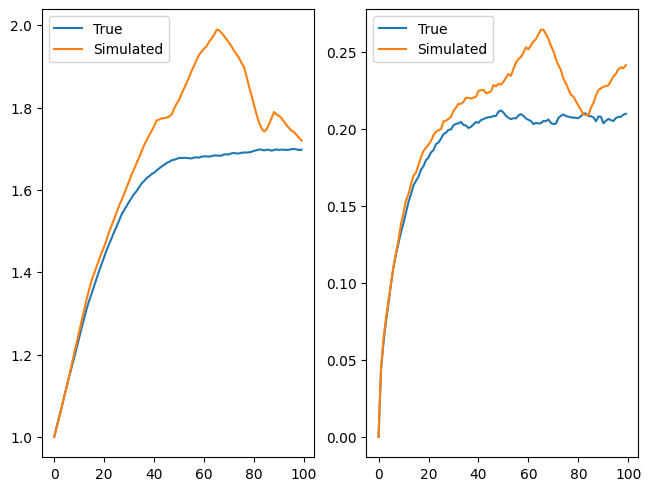

In [ ]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)

nn_sim_prices = np.vstack(S_t_list)

ax[0].plot(val_sim_prices[:, :10_000].mean(axis=1), label="True")
ax[0].plot(nn_sim_prices.mean(axis=1), label="Simulated")
ax[0].legend()

ax[1].plot(val_sim_prices[:, :10_000].std(axis=1), label="True")
ax[1].plot(nn_sim_prices.std(axis=1), label="Simulated")
ax[1].legend()

plt.show()

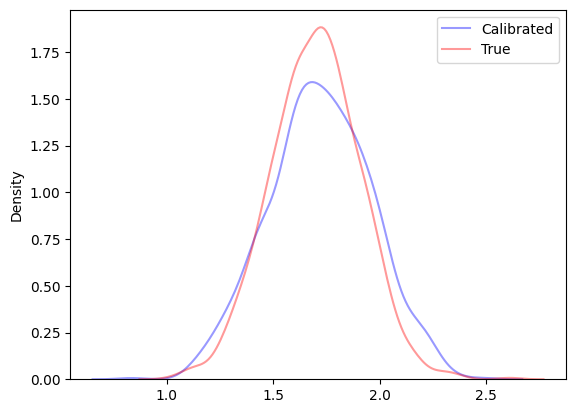

In [ ]:
final_sim_prices = np.vstack(S_t_list)[-1]
final_val_sim_prices = val_sim_prices[-1]

sns.kdeplot(final_sim_prices, alpha=0.4, color="blue", label="Calibrated")
sns.kdeplot(final_val_sim_prices, alpha=0.4, color="red", label="True")
plt.legend()
plt.show()